*David Schlangen, 2019-03-20*

# Task: Computing Denotations

This notebook gives an overview of the image corpora that we have looked at so far. Many of these corpora have been used to create further annotation. Here, we only look at the corpora themselves -- that is, the types of images that can be found in them -- and the basic annotation that comes with them. Further annotations that we have looked at will be discussed in the notebooks in `03_Tasks`.

This notebook is part of a collection of notebooks. The series starts with `01_SemPics` and `02_ImageCorpora` (which should be read in that order) and continues with the notebooks in the current directory, `03_Tasks`, which can be read in any order.

## Introduction

Following the perspective explained in `01_SemPics`, this notebook here looks at tasks that can be conceptualised as requiring the computation of the value of the *denotation function*, $[\![\cdot]\!]$. More specifically, we will look into how we can use the expression/image relation that we find in the data, *annotates*, with that denotation relation (
$\mathcal{R}_{e/I} = \{ \mathit{annotates}, [\![\cdot]\!]\}$).

We will look at examples of pairs of expression and image objects roughly in order of increasing size and complexity. In the tradition of formal semantics, one would set this up in such a way that the output for more complex expressions is composed out of that for its constituents. We stay agnostic with respect to the actual details of the implementation, however.

What we do here is only to provide a *description* of the task and its inner structure; and to give some hints on how datasets could be constructed that make it possible to learn and evaluate models for it.

In [4]:
# imports

from itertools import chain, permutations, combinations
from collections import Counter
import configparser
import os
from textwrap import fill
import scipy
import sys
import csv
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [86]:
# Load up config file (needs path; adapt env var if necessary); local imports

config = configparser.ConfigParser()
my_config = '../Config/default.cfg'
with open(my_config, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append('../Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b, get_image_part

sys.path.append('../WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational

sys.path.append('../Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../../sempix-master/Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [5]:
# Load up preprocessed DataFrames. 
df_names = [
            'saiapr_bbdf',
            'mscoco_bbdf',
            'saiapr_refdf',
            'refcoco_refdf'
           ]
df = load_dfs(preproc_path, df_names)


# Load mapping from category ID to category name
saiapr_cat_path = os.path.join(config.get('SAIAPR', 'saiapr_base'),
                               'SAIA_Data/benchmark/wlist.txt')

saiapr_cat = {}
with open(saiapr_cat_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        saiapr_cat[int(row[0])] = row[1]

In [7]:
saiapr_cat

{1: '',
 2: 'aerostatic-balloon',
 3: 'air-vehicles',
 4: 'airplane',
 5: 'ancent-building',
 6: 'animal',
 7: 'ant',
 8: 'antelope',
 9: 'ape',
 10: 'apple',
 11: 'arctic',
 12: 'astronaut',
 13: 'baby',
 14: 'ball',
 15: 'balloon',
 16: 'beach',
 17: 'bear',
 18: 'beaver',
 19: 'bed',
 20: 'beetle',
 21: 'bench',
 22: 'bicycle',
 23: 'bird',
 24: 'boat',
 25: 'boat-rafting',
 26: 'bobcat-wildcat',
 27: 'book',
 28: 'bottle',
 29: 'branch',
 30: 'bridge',
 31: 'building',
 32: 'bull',
 33: 'bus',
 34: 'bush',
 35: 'butterfly',
 36: 'cabin',
 37: 'cactus',
 38: 'camel',
 39: 'camera',
 40: 'can',
 41: 'canine',
 42: 'cannon',
 43: 'car',
 44: 'caribou',
 45: 'castle',
 46: 'cat',
 47: 'caterpillar',
 48: 'cello',
 49: 'chair',
 50: 'cheetah',
 51: 'child',
 52: 'child-boy',
 53: 'child-girl',
 54: 'chimney',
 55: 'church',
 56: 'church-interior',
 57: 'city',
 58: 'clock',
 59: 'cloth',
 60: 'cloud',
 61: 'column',
 62: 'construction',
 63: 'construction-other',
 64: 'coral',
 65: 'cou

As a reminder, this is where we left things. Here is one of the example images again, with information about the locations of objects overlayed on top of the image. The objects are identified with numerical identifiers. We said that we can see this information as constituting one part of a semantic model, the *domain* $D$, with the elements of that set being image patches, and that we can read from the additional annotation, among other things, the implied interpretation for the word *woman*.

<IPython.core.display.Latex object>

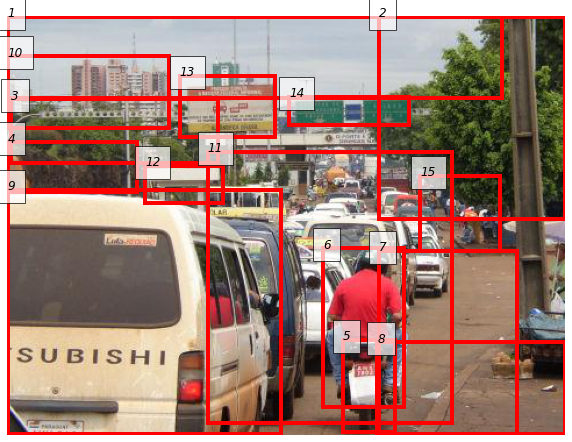

In [21]:
# load up an image & overlay its bounding boxes and object IDs.
pick_row = 10
ic, ii  = df['saiapr_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['saiapr_bbdf'], (ic, ii), column=['bb', 'region_id']).values

display(Latex("$D = \\{" + ', '.join(['o_{' + str(rg) + '}' for _, rg in this_anno]) + "\\}$"))

plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno])

In [22]:
# objects in image
outcols = 'i_corpus image_id region_id refexp'.split()
img_df = query_by_id(df['saiapr_refdf'], (ic, ii), column=outcols)
img_df

i_corpus  image_id  region_id  \
10             0      2884         12   
6897           0      2884          3   
8962           0      2884          8   
10286          0      2884          1   
16128          0      2884         15   
16296          0      2884         14   
27512          0      2884          7   
31920          0      2884         11   
39698          0      2884          5   
51398          0      2884         13   
52969          0      2884          4   
56093          0      2884          6   
65395          0      2884          2   
71408          0      2884          9   
87829          0      2884         10   
101945         0      2884          7   

                                            refexp  
10                   white building over white van  
6897           top of trees on left under building  
8962                                  bottom right  
10286                                          sky  
16128       orange person in background under tree  
16296                            green street sign  
27512                                          yep  
31920   cars that arent the motocycle or white van  
39698                                    motorbike  
51398                                         sign  
52969                   right above mitsubishi car  
56093                                          red  
65395                                  trees right  
71408                               white car left  
87829                            building top left  
101945             road next to man with red shirt

In [23]:
i_trees = [reg for ic,ii,reg in create_word2den(img_df)['trees']]
i_trees

[2, 3]

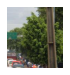

In [24]:
for this_obj in i_trees:
    this_bb = [int(e) for e in [e[0] for e in this_anno if e[1] == this_obj][0]]
    plot_img_cropped(get_image_filename(config, ic, ii), this_bb, width=1, height=2)

In [25]:
# get denotation of "trees" from referring expressions for this image

display(Latex('$I(trees) = \\{' + ', '.join(['o_{' + str(i) + '}' for i in i_trees]) + '\\}$'))
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno if reg in i_trees])

<IPython.core.display.Latex object>

With this reconceptualisation of what the corpora give us, we can now see if we take the path from simple to complex expressions, and how they can be mapped into their denotations. The corpora give us ample material for this. The main task in the background will be that of *evaluating* the expression, given an image. We will also be interested in the question of whether how a model might *explain* the evaluation it provides. 

Some of the expressions that we will look at will be automatically extracted parts of longer expressions and as such cannot count as "real" attested examples of language use. Others however, will be in exactly the form as produced by the annotators of the original corpus. We will also touch on the question of whether such expression may tell us interesting things about the linguistic choices made by the annotators in the given context.

## Single Words

### Nouns

We'll start with an example of a type of annotation that is *not* as helpful as one might at first think. 

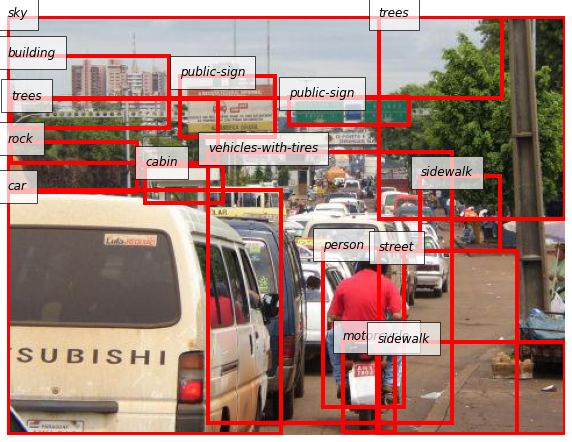

In [28]:
# plot saiapr categories on image
this_anno = query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'cat']).values
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, saiapr_cat[cat]) for b, cat in this_anno])

We could now try to use this annotation to learn the interpretation function for these words, but unfortunately, we wouldn't get very far with this, as COCO uses a set of only 80 different categories. (And hence we would end up with a vocabulary of only this size.)

The "Visual Genome" corpus gives us a more fertile hunting ground. Here, the image objects are also annotated with single words (in the terminology of this corpus, their *names*), but instead of being taken from a pre-specified set of labels, these are taken from larger, freely-formulated expressions that were provided by annotators. (The "region descriptions" discussed in the corpus overview, and in more detail below.)

As the following numbers and diagrams show, there is a large number of types in this set of names, with a decently populated long tail (but note that this number will likely be inflated by typos and annotation artefacts):

In [31]:
df['saiapr_refdf'].head()

i_corpus  image_id  region_id r_corpus  rex_id  \
0         0      8756          2  referit       0   
1         0     21905          1  referit       1   
2         0     14576          1  referit       2   
3         0     15169          5  referit       3   
4         0      6263          1  referit       4   

                                refexp  \
0                   sunray at very top   
1                                  sky   
2                                 seal   
3  the sand in the bottom right corner   
4                            dirt path   

                                                                                  tagged  
0                                        [[sunray, NN], [at, IN], [very, RB], [top, JJ]]  
1                                                                            [[sky, NN]]  
2                                                                           [[seal, NN]]  
3  [[the, DT], [sand, NN], [in, IN], [the, DT], [bottom, JJ], [right, NN], [corner, NN]]  
4                                                               [[dirt, NN], [path, NN]]

In [73]:
# show all refexps for a given region
pick_row = 100
ic, ii  = df['saiapr_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'region_id']).values

pick_object = 4
ri = this_anno[pick_object][1]

refexps = query_by_id(df['saiapr_refdf'], (ic, ii, ri), 'refexp')
for refexp in refexps:
    print('- ', refexp)
    
bbs = [(bb[0], ('', 'green')) for bb in this_anno]
bbs.append((query_by_id(df['saiapr_bbdf'], (ic, ii, ri), 'bb')[0], ''))

plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

-  closest chair


In [75]:
# some statistics about available refexps
names_refdfs = ['saiapr_refdf', 'refcoco_refdf']
for name, size in zip(names_refdfs, map(len, [df[n] for n in names_refdfs])):
    avglen = df[name]['refexp'].str.split().apply(len).mean()
    print("{:>20}: {:>8,} refexps; avg. # words: {:.2f}".format(name, size, avglen))

        saiapr_refdf:  120,081 refexps; avg. # words: 3.43
       refcoco_refdf:  142,210 refexps; avg. # words: 3.50


In [76]:
# some stats about vocabulary...
def get_vocab(inlist):
    tmp = ' '.join(inlist).split()
    return len(tmp), list(set(tmp))
def get_vocab_refdf(df):
    return get_vocab(df['refexp'].tolist())

vocab = {}
refexp_corps = ['saiapr_refdf', 'refcoco_refdf']
for this_corp in refexp_corps:
    n_tok, vocab[this_corp] = get_vocab_refdf(df[this_corp])
    print('{:>20}:    size vocab: {:>8,}  type/token: {:.4f} '.format(
        this_corp, len(vocab[this_corp]), len(vocab[this_corp]) / n_tok))
    
# TODO: intersection of all permutations, size of vocab

        saiapr_refdf:    size vocab:   10,058  type/token: 0.0244 
       refcoco_refdf:    size vocab:   10,341  type/token: 0.0208 


## Relational NPs / Prepositional Phrases

### ... in the referring expression corpora

Some of the referring expressions in the corpora work by relating the target referent to another object. We can filter out such utterances, using a list of prepositions like "below", "above", etc.:

In [77]:
# show some relational referring expressions from RefCoco
relmask = df['saiapr_refdf']['refexp'].apply(is_relational)
for refexp in df['saiapr_refdf'][relmask].head(10)['refexp'].tolist():
    print(refexp)

water to the left of the tower but above wire
boat on laft side in water - not red
patch of snow to the middle left below second animal
paper on the wall to right of people
plant to the left of the front woman
people behind dude in middle
wall behind man
cloud area just above mtn on far right
white fog in middle of mountain
tree behind the guy


In [78]:
# proportion of relation expressions in refcoco:
print("proportion of relational expr. in saiapr: {:.3}%".format(
    relmask.sum() / len(df['saiapr_refdf']) * 100))

proportion of relational expr. in saiapr: 13.9%


(Before we move on, note the non-standard syntax (at least for writing) of some of the expressions, where articles are dropped; "black van in front of cab" instead of "*the* black van in front of *the* cab". This is presumably another effect of the setting which incentivises for efficiency.)

These constructions work by locating the *target object* via a *landmark object* (e.g., the *black van* via the *cab*, in "black van in front of cab"). To compute their denotation it is necessary to learn what the contribution of the relation is; for this, it is necessary to know the denotation not only of the expression as a whole, but also of the landmark individually. Unfortunately, this is not something that the corpora discussed so far give us. (\cite{Cirik2018b} provide this for a small part of GoogleREX.) For this, we need to turn to visual genome (and away from referring expressions).

* **Dataset:** relational referring expressions (NPs containing PPs)
* **Negative Instances:** negative sampling, from other objects in image (or from other images)
* **Source:** ReferIt, RefCoco, RefCoco+, GoogleRex
* **Uses:** learn interpretation function of relational expressions; evaluate (or tune) composition function. Caveat: not all arguments of relation resolved in corpus.

In [79]:
def get_patch_from_triple(row, resize=True, xs=224, ys=224):
    # get_image_part() return tuple, we only need the image patch
    out = get_image_part(config, (None, None),
                          row['i_corpus'], row['image_id'], row['bb'], resize=resize, xs=xs, ys=ys)[1]
    return out

In [80]:
def get_all_objects(df, name):
    return df[df['name'] == name]['i_corpus image_id bb'.split()]

In [81]:
def plot_grid(img_list, n_cols=10, figsize=(15, 15)):
    n = len(img_list)
    n_rows = n // n_cols + (1 if n % n_cols else 0)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    fig.subplots_adjust(hspace=0, wspace=0)

    for n, img in enumerate(img_list):
        this_ax = ax[n // n_cols, n % n_cols]
        this_ax.imshow(img)
        this_ax.axis('off')

In [82]:
def sample_n_get_patch(df, name, n=100):
    out = []
    for i, row in get_all_objects(df, name).sample(n).iterrows():
        out.append(get_patch_from_triple(row))
    return out

In [84]:
def plot_ref_word(df, w2d, word, n=100):
    mcols = 'i_corpus image_id region_id'.split()
    tmpdf = pd.DataFrame(w2d[word], columns=mcols)
    n = min(n, len(tmpdf))
    out = []
    for m, row in pd.merge(df, tmpdf, how='inner', on=mcols).sample(n).iterrows():
        out.append(get_patch_from_triple(row))
    plot_grid(out)

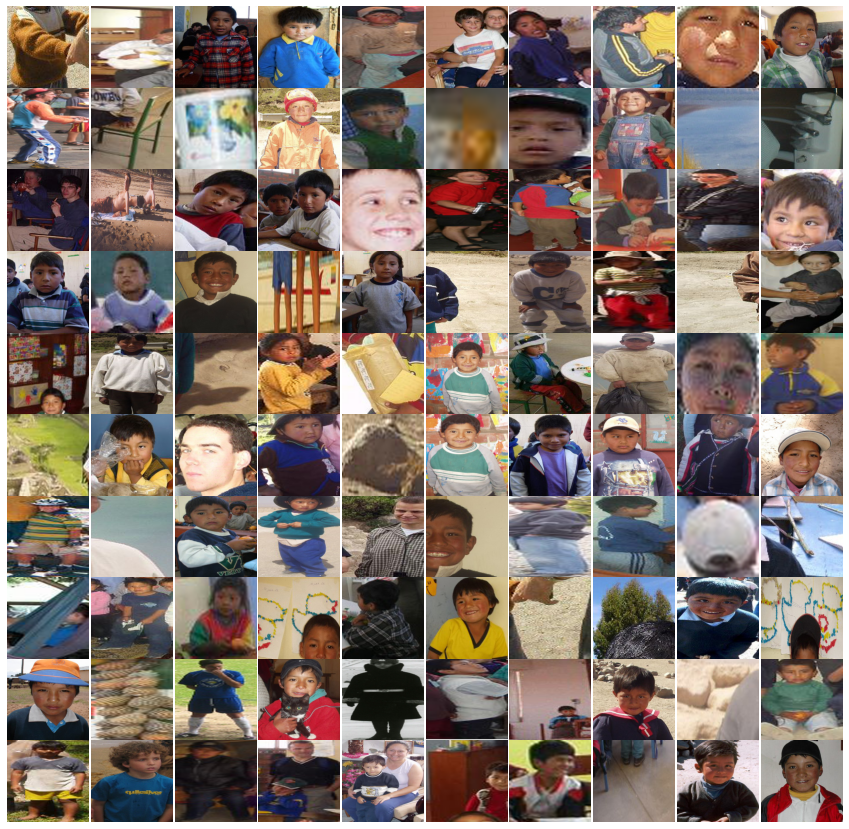

In [87]:
w2d_saiapr = create_word2den(df['saiapr_refdf'])
plot_ref_word(df['saiapr_bbdf'], w2d_saiapr, 'boy')

In [88]:
plot_ref_word(df['saiapr_bbdf'], w2d_saiapr, 'red')